# Evaluación Parcial 3: Modelos de Machine Learning No Supervisado

## Informe de Implementación de Clustering

**Asignatura:** MLY0100 - Machine Learning  
**Metodología:** CRISP-DM  
**Tipo de Modelo:** Aprendizaje No Supervisado (Clustering)  
**Contexto:** Análisis de segmentación de películas cinematográficas

---

## Índice

1. [Fase 1: Comprensión del Negocio](#fase-1)
2. [Fase 2: Comprensión de los Datos](#fase-2)
3. [Fase 3: Preparación de Datos](#fase-3)
4. [Fase 4: Modelado No Supervisado](#fase-4)
5. [Fase 5: Evaluación](#fase-5)
6. [Fase 6: Despliegue y Conclusiones](#fase-6)

---

## Objetivo del Proyecto

Implementar modelos de clustering para segmentar películas cinematográficas basándose en sus características intrínsecas (duración, puntuación, año de estreno, género) con el fin de identificar patrones ocultos y grupos naturales que permitan:

- **Segmentación de catálogo**: Agrupar películas similares para recomendaciones personalizadas
- **Análisis de mercado**: Identificar nichos de películas con características similares
- **Estrategia de contenido**: Comprender qué tipos de películas comparten características comunes



<a id="fase-1"></a>
## Fase 1: Comprensión del Negocio

### 1.1 Diferencias entre Modelos Supervisados y No Supervisados

#### Modelos Supervisados
Los modelos supervisados aprenden a partir de datos etiquetados, donde conocemos la variable objetivo (target) que queremos predecir.

**Características:**
- Requieren datos etiquetados (ej: clasificación de películas por rating de edad)
- Objetivo: Predecir una variable objetivo conocida
- Ejemplos: Clasificación (rating PG/R/ATP) y Regresión (predicción de puntuación)
- Métricas: Accuracy, Precision, Recall, R², RMSE

**En nuestro contexto:**
- Fase 4 (Clasificación): Predecir nivel de éxito comercial (Alto/Medio/Bajo)
- Fase 4 (Regresión): Predecir rating numérico de películas

#### Modelos No Supervisados
Los modelos no supervisados descubren patrones ocultos en datos sin etiquetas, identificando estructuras naturales en los datos.

**Características:**
- No requieren datos etiquetados
- Objetivo: Descubrir patrones, grupos o estructuras ocultas
- Ejemplos: Clustering (K-Means, DBSCAN), Reducción de dimensionalidad (PCA)
- Métricas: Silhouette Score, Davies-Bouldin Index, Inertia (WCSS)

**En nuestro contexto:**
- Segmentar películas en grupos naturales según características similares
- Identificar nichos de mercado no evidentes
- Descubrir relaciones entre géneros, duraciones y puntuaciones

### 1.2 Casos de Uso del Aprendizaje No Supervisado

#### Ventajas:
1. **Descubrimiento de patrones ocultos**: Identificar grupos que no son evidentes a simple vista
2. **No requiere etiquetas**: Útil cuando no tenemos datos etiquetados o son costosos de obtener
3. **Exploración de datos**: Ayuda a entender la estructura interna de los datos
4. **Segmentación de mercado**: Agrupar clientes/productos con características similares

#### Desventajas:
1. **Interpretación subjetiva**: Los resultados requieren interpretación humana
2. **Validación difícil**: No hay una "respuesta correcta" para comparar
3. **Sensibilidad a parámetros**: Requiere ajuste cuidadoso de hiperparámetros
4. **Escalabilidad**: Algunos algoritmos pueden ser computacionalmente costosos

#### Aplicación en el Negocio Cinematográfico:
- **Recomendaciones**: Agrupar películas similares para sistemas de recomendación
- **Marketing**: Identificar segmentos de audiencia con preferencias similares
- **Adquisición de contenido**: Plataformas streaming pueden identificar tipos de películas que faltan en su catálogo
- **Análisis de tendencias**: Descubrir qué combinaciones de características son más populares



<a id="fase-2"></a>
## Fase 2: Comprensión de los Datos

### 2.1 Importación de Librerías

Para este análisis utilizaremos las siguientes librerías de Python:

- **numpy**: Operaciones numéricas y arrays
- **pandas**: Manipulación y análisis de datos
- **scikit-learn**: Algoritmos de Machine Learning (KMeans, DBSCAN, métricas)
- **matplotlib y seaborn**: Visualización de datos
- **scipy**: Estadísticas y análisis avanzado



In [1]:
# =============================================================================
# IMPORTAR LIBRERÍAS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Machine Learning - No Supervisado
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score,
    adjusted_rand_score
)

# Estadísticas y análisis
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

print('✅ Librerías importadas correctamente')
print(f'NumPy versión: {np.__version__}')
print(f'Pandas versión: {pd.__version__}')
print(f'Scikit-learn disponible para clustering')



✅ Librerías importadas correctamente
NumPy versión: 2.2.4
Pandas versión: 2.2.3
Scikit-learn disponible para clustering


### 2.2 Carga de Datos

Cargamos los datasets necesarios para el análisis de clustering. Necesitamos combinar información de películas (duración, puntuación, año) con géneros y décadas para tener un conjunto completo de características.



In [2]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
# Configurar rutas
project_path = Path.cwd() if (Path.cwd() / "pyproject.toml").exists() else Path.cwd().parent
data_path = project_path / "data"

# Cargar datasets
print("📂 Cargando datasets...")
movies = pd.read_csv(data_path / "01_raw" / "movies.csv", encoding='latin-1')
genres = pd.read_csv(data_path / "01_raw" / "genres.csv", encoding='latin-1')
final_df = pd.read_csv(data_path / "03_primary" / "final_df.csv", encoding='latin-1')

print(f"✅ Movies cargado: {movies.shape}")
print(f"✅ Genres cargado: {genres.shape}")
print(f"✅ Final_df cargado: {final_df.shape}")

# Mostrar estructura de datos
print("\n📊 Estructura de Movies:")
print(movies.head())
print("\n📊 Columnas disponibles:")
print(movies.columns.tolist())
print("\n📊 Información del dataset:")
print(movies.info())



📂 Cargando datasets...
✅ Movies cargado: (941597, 7)
✅ Genres cargado: (1046849, 2)
✅ Final_df cargado: (102060, 3)

📊 Estructura de Movies:
        id                               name    date  \
0  1000001                             Barbie  2023.0   
1  1000002                           Parasite  2019.0   
2  1000003  Everything Everywhere All at Once  2022.0   
3  1000004                         Fight Club  1999.0   
4  1000005                         La La Land  2016.0   

                                            tagline  \
0                  She's everything. He's just Ken.   
1                       Act like you own the place.   
2  The universe is so much bigger than you realize.   
3                           Mischief. Mayhem. Soap.   
4                    Here's to the fools who dream.   

                                         description  minute  rating  
0  Barbie and Ken are having the time of their li...   114.0    3.86  
1  All unemployed, Ki-taek's family takes p

### 2.3 Análisis Exploratorio de Datos (EDA)

Realizamos un análisis exploratorio para entender la distribución de las variables numéricas que utilizaremos para el clustering.



📊 ESTADÍSTICAS DESCRIPTIVAS

MINUTE:
count    760027.000000
mean         65.776516
std         154.828161
min           1.000000
25%          15.000000
50%          62.000000
75%          92.000000
max       72000.000000
Name: minute, dtype: float64
Valores nulos: 181570 (19.28%)

RATING:
count    90999.000000
mean         3.244043
std          0.417281
min          0.880000
25%          3.020000
50%          3.300000
75%          3.510000
max          4.690000
Name: rating, dtype: float64
Valores nulos: 850598 (90.34%)

DATE:
count    849684.000000
mean       1998.522300
std          27.534865
min        1874.000000
25%        1986.000000
50%        2010.000000
75%        2019.000000
max        2031.000000
Name: date, dtype: float64
Valores nulos: 91913 (9.76%)


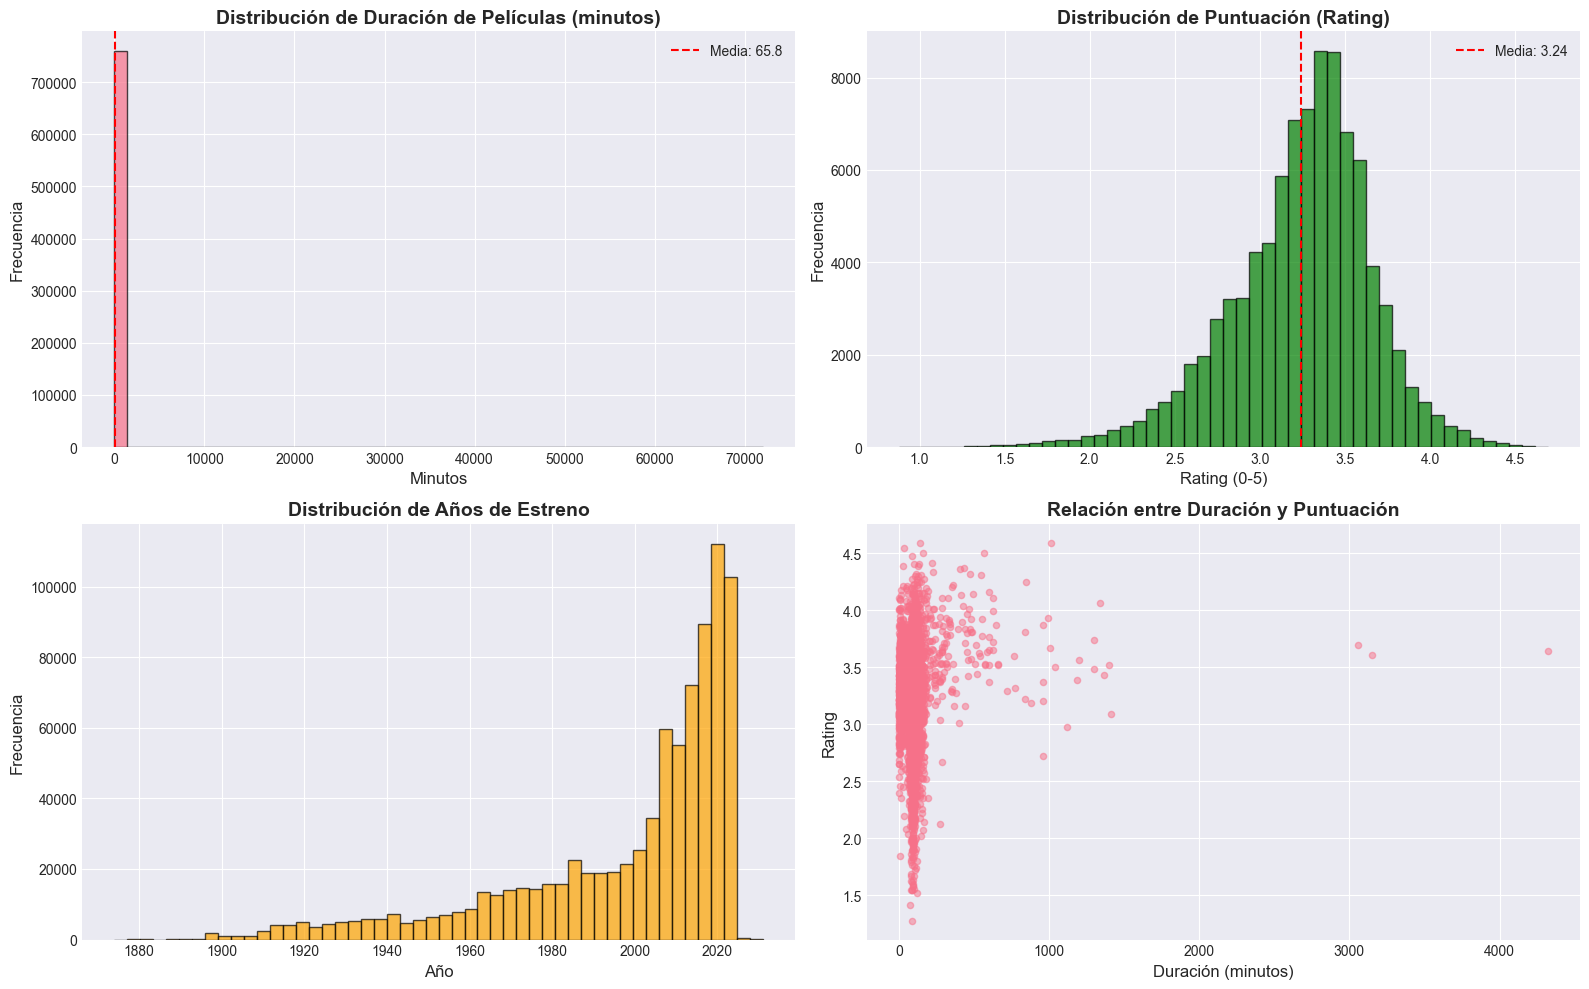


✅ Análisis exploratorio completado


In [3]:
# =============================================================================
# ANÁLISIS EXPLORATORIO DE DATOS
# =============================================================================
# Estadísticas descriptivas de variables numéricas
print("=" * 60)
print("📊 ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 60)

numeric_cols = ['minute', 'rating', 'date']
for col in numeric_cols:
    if col in movies.columns:
        print(f"\n{col.upper()}:")
        print(movies[col].describe())
        print(f"Valores nulos: {movies[col].isna().sum()} ({movies[col].isna().sum()/len(movies)*100:.2f}%)")

# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribución de duración (minute)
if 'minute' in movies.columns:
    axes[0, 0].hist(movies['minute'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribución de Duración de Películas (minutos)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Minutos')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].axvline(movies['minute'].mean(), color='red', linestyle='--', label=f'Media: {movies["minute"].mean():.1f}')
    axes[0, 0].legend()

# Distribución de rating
if 'rating' in movies.columns:
    axes[0, 1].hist(movies['rating'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[0, 1].set_title('Distribución de Puntuación (Rating)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Rating (0-5)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].axvline(movies['rating'].mean(), color='red', linestyle='--', label=f'Media: {movies["rating"].mean():.2f}')
    axes[0, 1].legend()

# Distribución de año (date)
if 'date' in movies.columns:
    axes[1, 0].hist(movies['date'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 0].set_title('Distribución de Años de Estreno', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Año')
    axes[1, 0].set_ylabel('Frecuencia')

# Relación entre minute y rating
if 'minute' in movies.columns and 'rating' in movies.columns:
    sample_data = movies[['minute', 'rating']].dropna().sample(min(5000, len(movies)), random_state=42)
    axes[1, 1].scatter(sample_data['minute'], sample_data['rating'], alpha=0.5, s=20)
    axes[1, 1].set_title('Relación entre Duración y Puntuación', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Duración (minutos)')
    axes[1, 1].set_ylabel('Rating')

plt.tight_layout()
plt.show()

print("\n✅ Análisis exploratorio completado")



<a id="fase-3"></a>
## Fase 3: Preparación de Datos

### 3.1 Integración y Limpieza de Datos

Para el clustering necesitamos crear un dataset integrado que combine:
- Información numérica de películas (duración, puntuación, año)
- Información categórica codificada (géneros, década)
- Eliminación de valores nulos y outliers extremos



In [4]:
# =============================================================================
# PREPARACIÓN DE DATOS PARA CLUSTERING
# =============================================================================
print("=" * 60)
print("🔧 PREPARACIÓN DE DATOS")
print("=" * 60)

# 1. Filtrar películas con datos completos
movies_clean = movies[['id', 'minute', 'rating', 'date']].copy()
movies_clean = movies_clean.dropna()

print(f"\n📊 Datos después de eliminar nulos: {movies_clean.shape}")

# 2. Filtrar outliers extremos (usando percentiles)
Q1_minute = movies_clean['minute'].quantile(0.01)
Q99_minute = movies_clean['minute'].quantile(0.99)
Q1_rating = movies_clean['rating'].quantile(0.01)
Q99_rating = movies_clean['rating'].quantile(0.99)

movies_clean = movies_clean[
    (movies_clean['minute'] >= Q1_minute) & (movies_clean['minute'] <= Q99_minute) &
    (movies_clean['rating'] >= Q1_rating) & (movies_clean['rating'] <= Q99_rating)
]

print(f"📊 Datos después de filtrar outliers: {movies_clean.shape}")

# 3. Integrar con géneros (obtener el género principal por película)
genres_main = genres.groupby('id')['genre'].first().reset_index()
movies_with_genres = movies_clean.merge(genres_main, on='id', how='left')

# 4. Integrar con década desde final_df
decade_info = final_df[['id', 'decade']].drop_duplicates()
movies_with_genres = movies_with_genres.merge(decade_info, on='id', how='left')

# 5. Filtrar solo películas de 2000s y 2010s (como en el proyecto original)
movies_clustering = movies_with_genres[
    (movies_with_genres['decade'].isin(['2000s', '2010s'])) &
    (movies_with_genres['genre'].notna())
].copy()

print(f"📊 Datos finales para clustering: {movies_clustering.shape}")
print(f"\n📊 Distribución por década:")
print(movies_clustering['decade'].value_counts())
print(f"\n📊 Top 10 géneros:")
print(movies_clustering['genre'].value_counts().head(10))

# 6. Crear variables numéricas para clustering
# Codificar década (2000s=0, 2010s=1)
movies_clustering['decade_encoded'] = movies_clustering['decade'].map({'2000s': 0, '2010s': 1})

# Crear variables dummy para géneros principales (top 10 géneros)
top_genres = movies_clustering['genre'].value_counts().head(10).index.tolist()
for genre in top_genres:
    movies_clustering[f'genre_{genre}'] = (movies_clustering['genre'] == genre).astype(int)

# Seleccionar características numéricas para clustering
feature_cols = ['minute', 'rating', 'date', 'decade_encoded'] + [f'genre_{g}' for g in top_genres]
X_clustering = movies_clustering[feature_cols].copy()

print(f"\n✅ Dataset preparado para clustering")
print(f"   - Muestras: {X_clustering.shape[0]}")
print(f"   - Características: {X_clustering.shape[1]}")
print(f"   - Características: {feature_cols}")

# Guardar IDs para referencia posterior
movie_ids = movies_clustering['id'].copy()



🔧 PREPARACIÓN DE DATOS

📊 Datos después de eliminar nulos: (90475, 4)
📊 Datos después de filtrar outliers: (87142, 4)
📊 Datos finales para clustering: (16269, 6)

📊 Distribución por década:
decade
2010s    10539
2000s     5730
Name: count, dtype: int64

📊 Top 10 géneros:
genre
Drama              2976
Comedy             2600
Documentary        2388
Horror             1430
Thriller           1148
Romance             815
Action              755
Animation           559
Science Fiction     484
Family              484
Name: count, dtype: int64

✅ Dataset preparado para clustering
   - Muestras: 16269
   - Características: 14
   - Características: ['minute', 'rating', 'date', 'decade_encoded', 'genre_Drama', 'genre_Comedy', 'genre_Documentary', 'genre_Horror', 'genre_Thriller', 'genre_Romance', 'genre_Action', 'genre_Animation', 'genre_Science Fiction', 'genre_Family']


### 3.2 Análisis de Correlaciones

Antes de aplicar clustering, es importante analizar las correlaciones entre las características numéricas para entender las relaciones entre variables y detectar posibles redundancias o multicolinealidad.


📊 ANÁLISIS DE CORRELACIONES

📈 Matriz de Correlación (Variables Numéricas):
        minute  rating   date
minute   1.000  -0.095 -0.095
rating  -0.095   1.000 -0.016
date    -0.095  -0.016  1.000


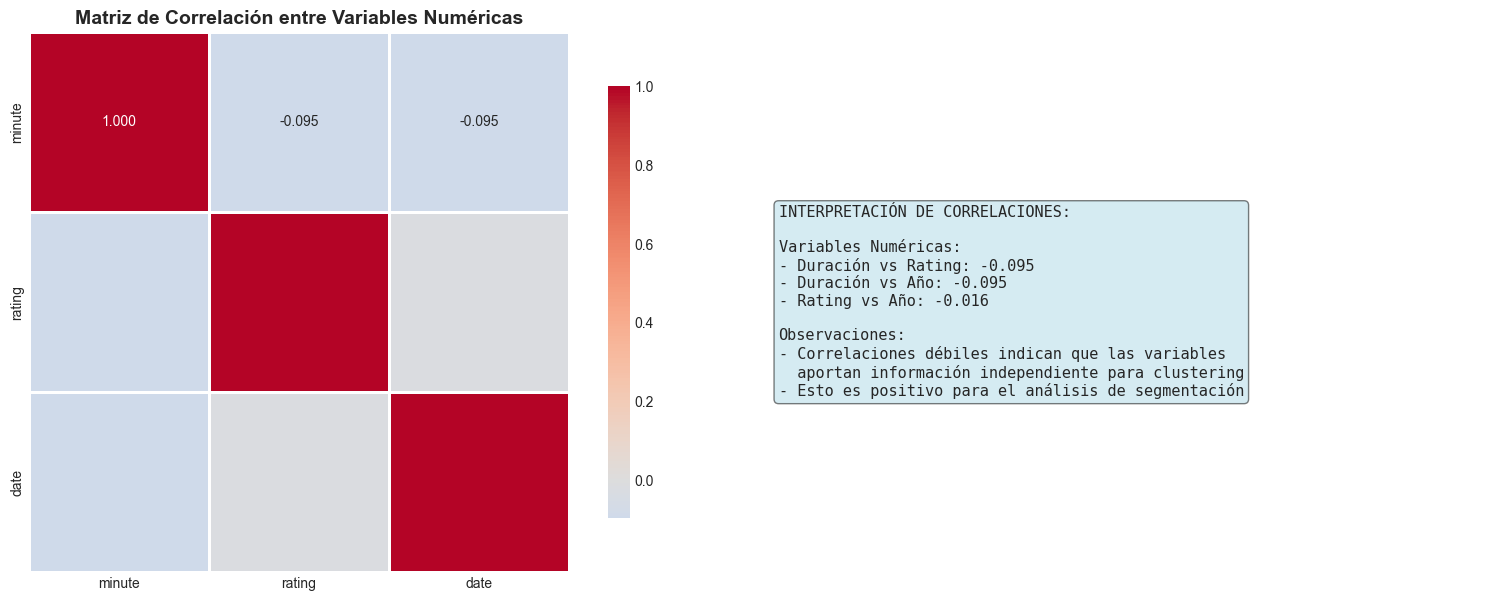


✅ Análisis de correlaciones completado


In [5]:
# =============================================================================
# ANÁLISIS DE CORRELACIONES ENTRE VARIABLES
# =============================================================================
print("=" * 60)
print("📊 ANÁLISIS DE CORRELACIONES")
print("=" * 60)

# Calcular matriz de correlación para variables numéricas
numeric_features = ['minute', 'rating', 'date']
correlation_matrix = movies_clustering[numeric_features].corr()

print("\n📈 Matriz de Correlación (Variables Numéricas):")
print(correlation_matrix.round(3))

# Visualización de correlaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap de correlaciones
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Matriz de Correlación entre Variables Numéricas', fontsize=14, fontweight='bold')

# Análisis de correlación con todas las características (incluyendo dummy de géneros)
correlation_full = X_clustering.corr()
axes[1].axis('off')
axes[1].text(0.1, 0.5, 
            f"INTERPRETACIÓN DE CORRELACIONES:\n\n"
            f"Variables Numéricas:\n"
            f"- Duración vs Rating: {correlation_matrix.loc['minute', 'rating']:.3f}\n"
            f"- Duración vs Año: {correlation_matrix.loc['minute', 'date']:.3f}\n"
            f"- Rating vs Año: {correlation_matrix.loc['rating', 'date']:.3f}\n\n"
            f"Observaciones:\n"
            f"- Correlaciones débiles indican que las variables\n"
            f"  aportan información independiente para clustering\n"
            f"- Esto es positivo para el análisis de segmentación",
            fontsize=11, verticalalignment='center', family='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✅ Análisis de correlaciones completado")


In [6]:
# =============================================================================
# NORMALIZACIÓN DE DATOS
# =============================================================================
# Usar StandardScaler para normalizar (media=0, desviación=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X_clustering.index)

print("✅ Datos normalizados con StandardScaler")
print(f"\n📊 Estadísticas antes de normalizar:")
print(X_clustering.describe().round(2))
print(f"\n📊 Estadísticas después de normalizar:")
print(X_scaled_df.describe().round(2))

# Verificar que la media es ~0 y desviación ~1
print(f"\n✅ Verificación de normalización:")
print(f"   Media (debe ser ~0): {X_scaled_df.mean().abs().max():.6f}")
print(f"   Desviación estándar (debe ser ~1): {X_scaled_df.std().abs().mean():.2f}")



✅ Datos normalizados con StandardScaler

📊 Estadísticas antes de normalizar:
         minute    rating      date  decade_encoded  genre_Drama  \
count  16269.00  16269.00  16269.00        16269.00     16269.00   
mean      86.54      3.09   2011.52            0.65         0.18   
std       31.89      0.44      5.58            0.48         0.39   
min        2.00      2.01   2000.00            0.00         0.00   
25%       81.00      2.77   2007.00            0.00         0.00   
50%       91.00      3.11   2013.00            1.00         0.00   
75%      102.00      3.43   2016.00            1.00         0.00   
max      476.00      4.15   2019.00            1.00         1.00   

       genre_Comedy  genre_Documentary  genre_Horror  genre_Thriller  \
count      16269.00           16269.00      16269.00        16269.00   
mean           0.16               0.15          0.09            0.07   
std            0.37               0.35          0.28            0.26   
min            0.00   

<a id="fase-4"></a>
## Fase 4: Modelado No Supervisado

### 4.1 Selección del Número Óptimo de Clusters

Antes de aplicar algoritmos de clustering, necesitamos determinar el número óptimo de clusters. Utilizaremos dos técnicas principales:

1. **Método del Codo (Elbow Method)**: Analiza la inercia (WCSS - Within-Cluster Sum of Squares) para diferentes valores de k
2. **Método de Silueta (Silhouette Method)**: Analiza el coeficiente de silueta promedio para diferentes valores de k

**Interpretación:**
- **Elbow Method**: Buscamos el punto donde la reducción de inercia se vuelve marginal (el "codo")
- **Silhouette Method**: Buscamos el valor de k que maximiza el coeficiente de silueta promedio (rango: -1 a 1, valores más altos son mejores)



🔍 MÉTODO DEL CODO (ELBOW METHOD)

🔄 Probando diferentes valores de k...
   k=2: Inercia=199051.30, Silhouette=0.1620
   k=3: Inercia=181841.29, Silhouette=0.1558
   k=4: Inercia=166082.15, Silhouette=0.1919
   k=5: Inercia=151161.01, Silhouette=0.2202
   k=6: Inercia=135651.64, Silhouette=0.2667
   k=7: Inercia=119611.08, Silhouette=0.3070
   k=8: Inercia=102026.33, Silhouette=0.3257
   k=9: Inercia=85583.50, Silhouette=0.3937
   k=10: Inercia=74442.38, Silhouette=0.3948


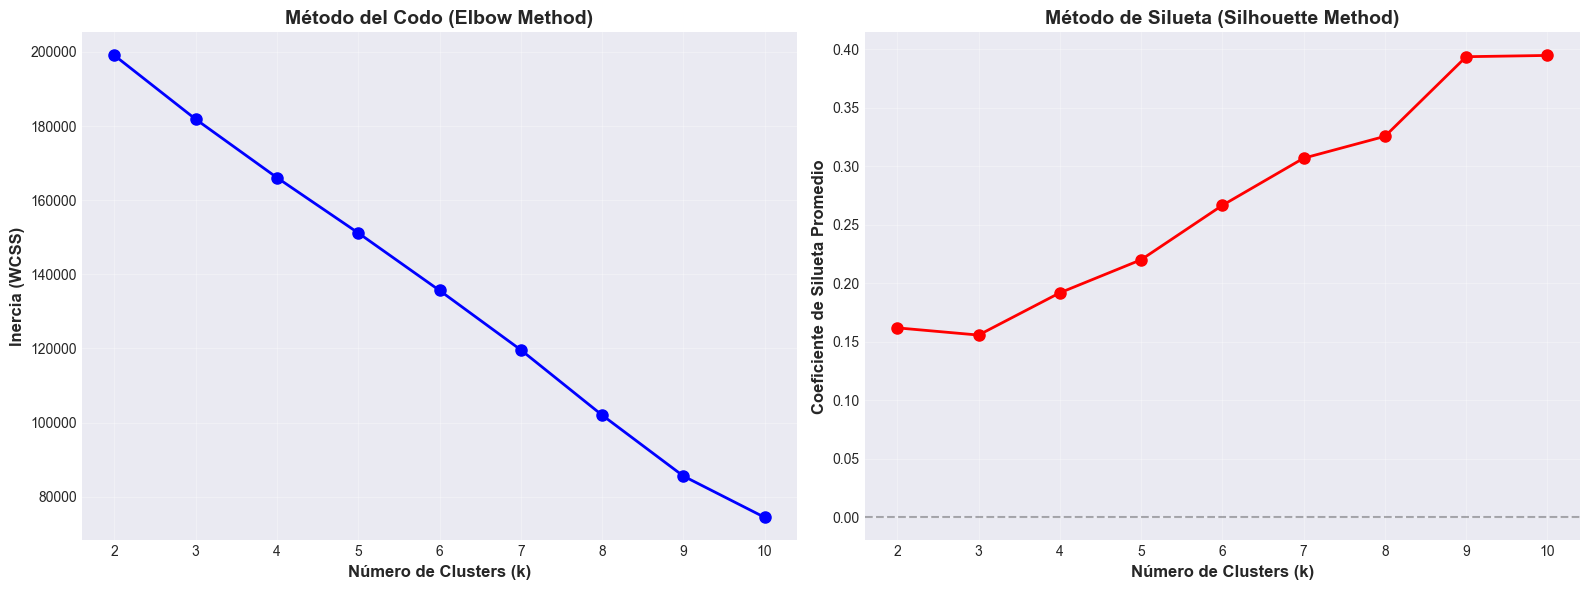


✅ Número óptimo de clusters según Silhouette: k=10
   Coeficiente de Silueta: 0.3948
✅ Número óptimo de clusters según Elbow: k=9

💡 Recomendación: Usar k=10 (basado en Silhouette Score)


In [7]:
# =============================================================================
# MÉTODO DEL CODO (ELBOW METHOD)
# =============================================================================
print("=" * 60)
print("🔍 MÉTODO DEL CODO (ELBOW METHOD)")
print("=" * 60)

# Probar diferentes valores de k
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("\n🔄 Probando diferentes valores de k...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    print(f"   k={k}: Inercia={kmeans.inertia_:.2f}, Silhouette={silhouette_avg:.4f}")

# Visualización del método del codo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de inercia (Elbow)
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inercia (WCSS)', fontsize=12, fontweight='bold')
axes[0].set_title('Método del Codo (Elbow Method)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Gráfico de Silhouette
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Coeficiente de Silueta Promedio', fontsize=12, fontweight='bold')
axes[1].set_title('Método de Silueta (Silhouette Method)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar k óptimo basado en Silhouette (máximo)
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ Número óptimo de clusters según Silhouette: k={optimal_k_silhouette}")
print(f"   Coeficiente de Silueta: {max(silhouette_scores):.4f}")

# Determinar k óptimo basado en Elbow (cálculo de la segunda derivada)
if len(inertias) >= 3:
    # Calcular la tasa de cambio (primera derivada)
    rate_of_change = np.diff(inertias)
    # Calcular la segunda derivada
    second_derivative = np.diff(rate_of_change)
    # El codo está donde la segunda derivada es máxima (cambio más pronunciado)
    elbow_idx = np.argmax(second_derivative) + 1  # +1 porque diff reduce el tamaño
    optimal_k_elbow = k_range[elbow_idx]
    print(f"✅ Número óptimo de clusters según Elbow: k={optimal_k_elbow}")

print(f"\n💡 Recomendación: Usar k={optimal_k_silhouette} (basado en Silhouette Score)")



🎯 IMPLEMENTACIÓN DE K-MEANS

🔧 Entrenando K-Means con k=10...
✅ K-Means entrenado exitosamente

📊 Distribución de películas por cluster:
0     484
1    2320
2    1430
3    3725
4     559
5    2388
6     484
7    1148
8    2976
9     755
Name: count, dtype: int64

📊 Porcentaje de distribución:
0     2.97
1    14.26
2     8.79
3    22.90
4     3.44
5    14.68
6     2.97
7     7.06
8    18.29
9     4.64
Name: count, dtype: float64

🔄 Reduciendo dimensionalidad con PCA para visualización...


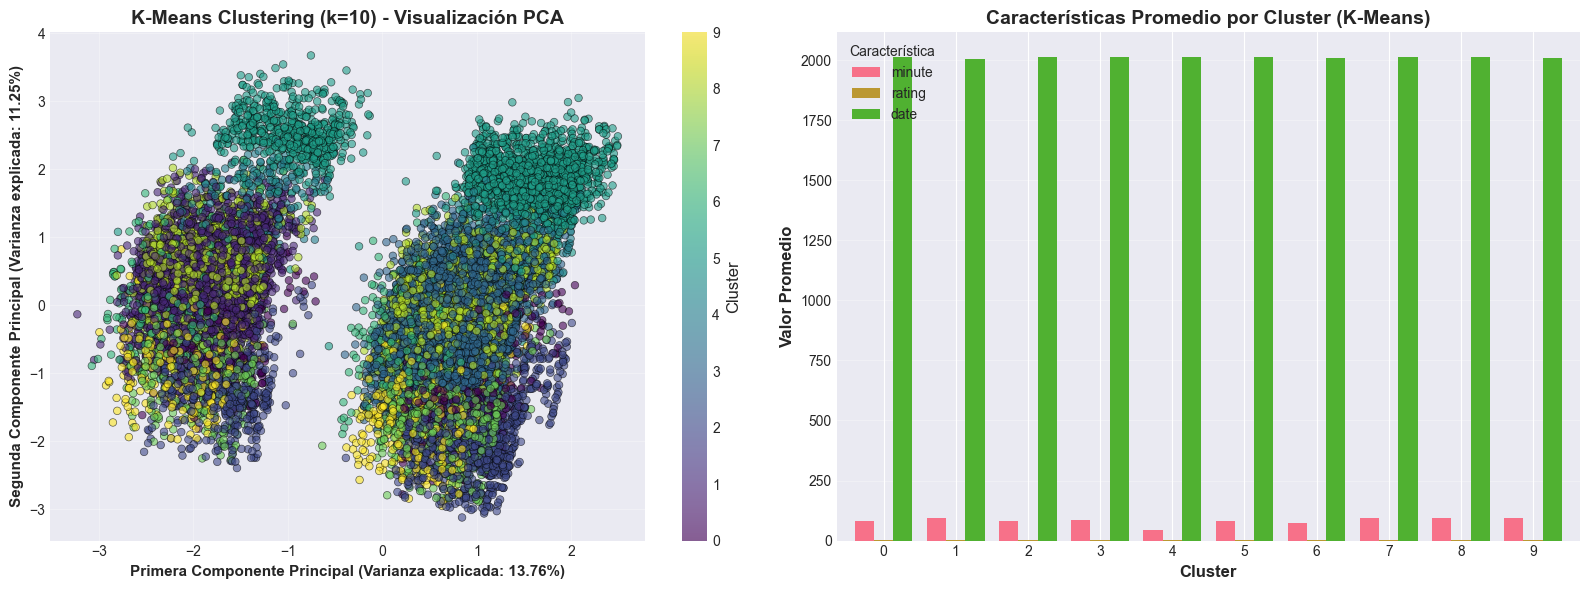


✅ Visualización completada
   Varianza total explicada por PCA: 25.01%


In [8]:
# =============================================================================
# K-MEANS CLUSTERING
# =============================================================================
print("=" * 60)
print("🎯 IMPLEMENTACIÓN DE K-MEANS")
print("=" * 60)

# Usar el k óptimo determinado anteriormente
k_optimal = optimal_k_silhouette
print(f"\n🔧 Entrenando K-Means con k={k_optimal}...")

# Entrenar K-Means
kmeans_model = KMeans(n_clusters=k_optimal, random_state=42, n_init=10, max_iter=300)
kmeans_labels = kmeans_model.fit_predict(X_scaled)

# Agregar etiquetas al dataset original
movies_clustering['cluster_kmeans'] = kmeans_labels

print(f"✅ K-Means entrenado exitosamente")
print(f"\n📊 Distribución de películas por cluster:")
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print(cluster_counts)
print(f"\n📊 Porcentaje de distribución:")
print((cluster_counts / len(kmeans_labels) * 100).round(2))

# Visualización de clusters (usando PCA para reducir a 2D)
print("\n🔄 Reduciendo dimensionalidad con PCA para visualización...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visualización en espacio PCA
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', 
                         alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'Primera Componente Principal (Varianza explicada: {pca.explained_variance_ratio_[0]:.2%})', 
                   fontsize=11, fontweight='bold')
axes[0].set_ylabel(f'Segunda Componente Principal (Varianza explicada: {pca.explained_variance_ratio_[1]:.2%})', 
                   fontsize=11, fontweight='bold')
axes[0].set_title(f'K-Means Clustering (k={k_optimal}) - Visualización PCA', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Visualización de características principales por cluster
cluster_means = movies_clustering.groupby('cluster_kmeans')[['minute', 'rating', 'date']].mean()
cluster_means.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Características Promedio por Cluster (K-Means)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor Promedio', fontsize=12, fontweight='bold')
axes[1].legend(title='Característica', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualización completada")
print(f"   Varianza total explicada por PCA: {pca.explained_variance_ratio_.sum():.2%}")



### 4.5 Análisis de Silhouette por Cluster Individual

El análisis de Silhouette por cluster individual nos permite identificar qué clusters están mejor definidos y cuáles podrían necesitar refinamiento.


📊 ANÁLISIS DE SILHOUETTE POR CLUSTER

📈 Silhouette Score por Cluster:
          Media  Desv. Est.  Cantidad
cluster                              
0        0.6142      0.0690       484
1        0.2473      0.0672      2320
2        0.5084      0.0911      1430
3        0.2103      0.0749      3725
4        0.5881      0.0518       559
5        0.4900      0.1137      2388
6        0.6179      0.0456       484
7        0.5525      0.0844      1148
8        0.3975      0.0902      2976
9        0.5654      0.0708       755


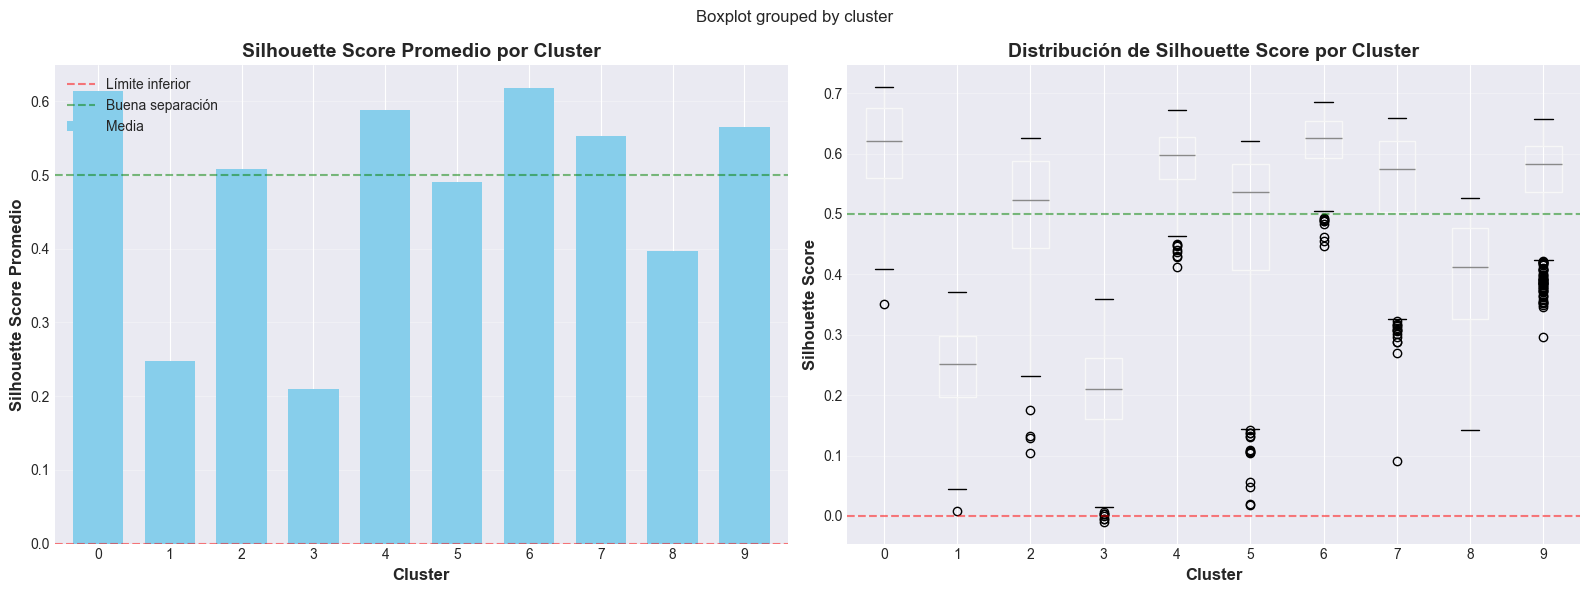


✅ Cluster con mejor separación: Cluster 6 (Silhouette: 0.6179)
✅ Cluster con peor separación: Cluster 3 (Silhouette: 0.2103)

✅ Análisis de Silhouette por cluster completado


In [9]:
# =============================================================================
# ANÁLISIS DE SILHOUETTE POR CLUSTER INDIVIDUAL
# =============================================================================
print("=" * 60)
print("📊 ANÁLISIS DE SILHOUETTE POR CLUSTER")
print("=" * 60)

from sklearn.metrics import silhouette_samples

# Calcular silhouette score por muestra
silhouette_samples_kmeans = silhouette_samples(X_scaled, kmeans_labels)

# Crear DataFrame con silhouette por cluster
silhouette_df = pd.DataFrame({
    'cluster': kmeans_labels,
    'silhouette': silhouette_samples_kmeans
})

# Estadísticas por cluster
print("\n📈 Silhouette Score por Cluster:")
cluster_silhouette_stats = silhouette_df.groupby('cluster')['silhouette'].agg(['mean', 'std', 'count'])
cluster_silhouette_stats.columns = ['Media', 'Desv. Est.', 'Cantidad']
print(cluster_silhouette_stats.round(4))

# Visualización de silhouette por cluster
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras: Silhouette promedio por cluster
cluster_silhouette_stats['Media'].plot(kind='bar', ax=axes[0], color='skyblue', width=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Límite inferior')
axes[0].axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Buena separación')
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Silhouette Score Promedio', fontsize=12, fontweight='bold')
axes[0].set_title('Silhouette Score Promedio por Cluster', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=0)

# Boxplot de distribución de silhouette por cluster
silhouette_df.boxplot(column='silhouette', by='cluster', ax=axes[1])
axes[1].set_title('Distribución de Silhouette Score por Cluster', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(y=0.5, color='green', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Identificar clusters con mejor y peor separación
best_cluster = cluster_silhouette_stats['Media'].idxmax()
worst_cluster = cluster_silhouette_stats['Media'].idxmin()

print(f"\n✅ Cluster con mejor separación: Cluster {best_cluster} (Silhouette: {cluster_silhouette_stats.loc[best_cluster, 'Media']:.4f})")
print(f"✅ Cluster con peor separación: Cluster {worst_cluster} (Silhouette: {cluster_silhouette_stats.loc[worst_cluster, 'Media']:.4f})")
print("\n✅ Análisis de Silhouette por cluster completado")


### 4.3 Análisis de Características por Cluster

Analizamos qué características definen cada cluster para entender la naturaleza de los grupos identificados.



📊 ANÁLISIS DETALLADO POR CLUSTER (K-MEANS)

🎬 CLUSTER 0 (484 películas, 3.0%)

📈 Características Numéricas Promedio:
   Duración (minutos): 83.3 ± 35.0
   Rating: 2.91 ± 0.45
   Año: 2012 ± 5.4

📅 Distribución por Década:
   2010s: 339 (70.0%)
   2000s: 145 (30.0%)

🎭 Top 5 Géneros:
   Science Fiction: 484 (100.0%)

🎬 CLUSTER 1 (2320 películas, 14.3%)

📈 Características Numéricas Promedio:
   Duración (minutos): 92.2 ± 28.8
   Rating: 3.08 ± 0.43
   Año: 2005 ± 2.9

📅 Distribución por Década:
   2000s: 2320 (100.0%)

🎭 Top 5 Géneros:
   Comedy: 1011 (43.6%)
   Romance: 337 (14.5%)
   Crime: 203 (8.8%)
   Adventure: 164 (7.1%)
   Music: 138 (5.9%)

🎬 CLUSTER 2 (1430 películas, 8.8%)

📈 Características Numéricas Promedio:
   Duración (minutos): 80.3 ± 29.1
   Rating: 2.76 ± 0.36
   Año: 2012 ± 5.5

📅 Distribución por Década:
   2010s: 972 (68.0%)
   2000s: 458 (32.0%)

🎭 Top 5 Géneros:
   Horror: 1430 (100.0%)

🎬 CLUSTER 3 (3725 películas, 22.9%)

📈 Características Numéricas Promedio:
  

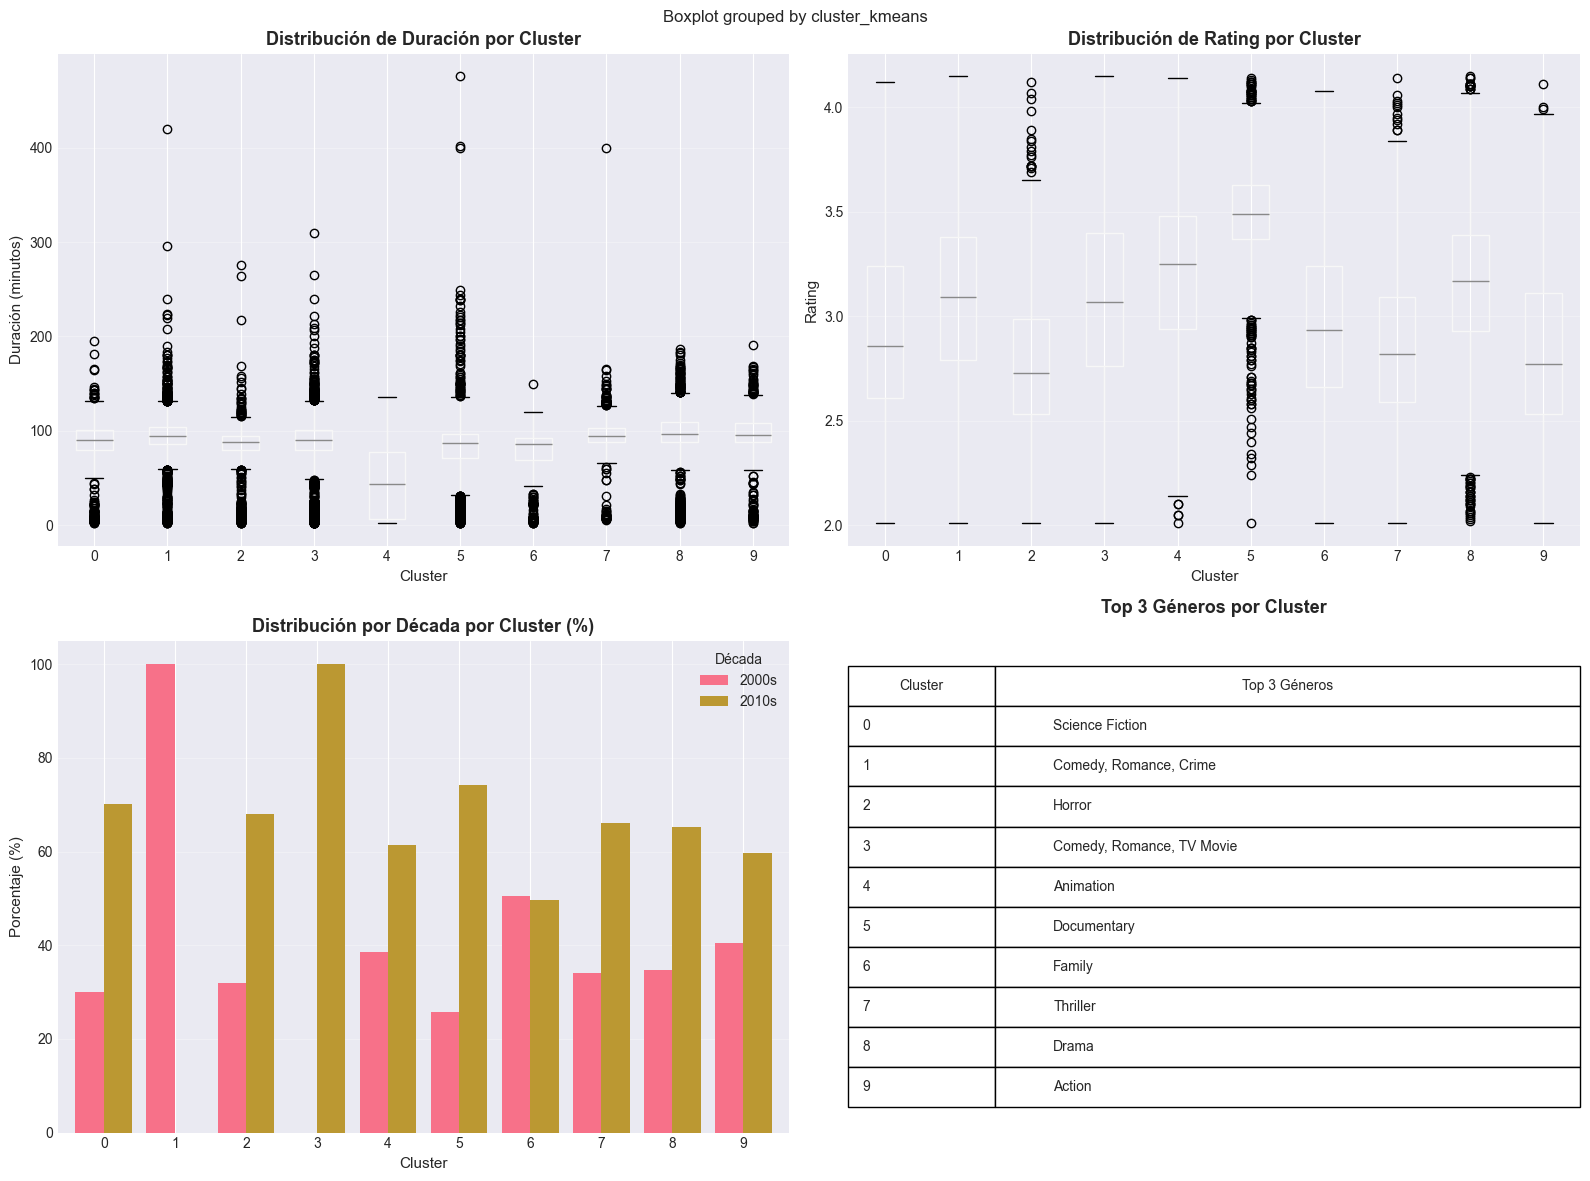


✅ Análisis por cluster completado


In [10]:
# =============================================================================
# ANÁLISIS DE CARACTERÍSTICAS POR CLUSTER
# =============================================================================
print("=" * 60)
print("📊 ANÁLISIS DETALLADO POR CLUSTER (K-MEANS)")
print("=" * 60)

for cluster_id in sorted(movies_clustering['cluster_kmeans'].unique()):
    cluster_data = movies_clustering[movies_clustering['cluster_kmeans'] == cluster_id]
    
    print(f"\n{'='*60}")
    print(f"🎬 CLUSTER {cluster_id} ({len(cluster_data)} películas, {len(cluster_data)/len(movies_clustering)*100:.1f}%)")
    print(f"{'='*60}")
    
    # Estadísticas numéricas
    print(f"\n📈 Características Numéricas Promedio:")
    print(f"   Duración (minutos): {cluster_data['minute'].mean():.1f} ± {cluster_data['minute'].std():.1f}")
    print(f"   Rating: {cluster_data['rating'].mean():.2f} ± {cluster_data['rating'].std():.2f}")
    print(f"   Año: {cluster_data['date'].mean():.0f} ± {cluster_data['date'].std():.1f}")
    
    # Distribución por década
    print(f"\n📅 Distribución por Década:")
    decade_dist = cluster_data['decade'].value_counts()
    for decade, count in decade_dist.items():
        print(f"   {decade}: {count} ({count/len(cluster_data)*100:.1f}%)")
    
    # Top géneros
    print(f"\n🎭 Top 5 Géneros:")
    genre_dist = cluster_data['genre'].value_counts().head(5)
    for genre, count in genre_dist.items():
        print(f"   {genre}: {count} ({count/len(cluster_data)*100:.1f}%)")

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de duración por cluster
movies_clustering.boxplot(column='minute', by='cluster_kmeans', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Duración por Cluster', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Cluster', fontsize=11)
axes[0, 0].set_ylabel('Duración (minutos)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Distribución de rating por cluster
movies_clustering.boxplot(column='rating', by='cluster_kmeans', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Rating por Cluster', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Cluster', fontsize=11)
axes[0, 1].set_ylabel('Rating', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Distribución por década
decade_cluster = pd.crosstab(movies_clustering['cluster_kmeans'], movies_clustering['decade'], 
                             normalize='index') * 100
decade_cluster.plot(kind='bar', ax=axes[1, 0], width=0.8)
axes[1, 0].set_title('Distribución por Década por Cluster (%)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Cluster', fontsize=11)
axes[1, 0].set_ylabel('Porcentaje (%)', fontsize=11)
axes[1, 0].legend(title='Década', fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=0)

# 4. Top géneros por cluster
top_genres_by_cluster = movies_clustering.groupby('cluster_kmeans')['genre'].apply(
    lambda x: x.value_counts().head(3).index.tolist()
)
genre_df = pd.DataFrame(top_genres_by_cluster).reset_index()
genre_df.columns = ['cluster', 'top_genres']
genre_df['top_genres_str'] = genre_df['top_genres'].apply(lambda x: ', '.join(x))
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=genre_df[['cluster', 'top_genres_str']].values,
                         colLabels=['Cluster', 'Top 3 Géneros'],
                         cellLoc='left',
                         loc='center',
                         colWidths=[0.2, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1, 1].set_title('Top 3 Géneros por Cluster', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n✅ Análisis por cluster completado")



### 4.6 Implementación de Clustering Jerárquico

El clustering jerárquico aglomerativo construye una jerarquía de clusters mediante un enfoque "bottom-up", donde cada observación comienza como su propio cluster y se fusionan pares de clusters sucesivamente.

**Ventajas:**
- No requiere especificar el número de clusters a priori
- Proporciona una jerarquía completa de clusters (dendrograma)
- Útil para visualizar relaciones entre clusters

**Desventajas:**
- Computacionalmente costoso para grandes datasets
- Sensible a outliers
- Difícil de escalar


🎯 IMPLEMENTACIÓN DE CLUSTERING JERÁRQUICO

📊 Usando muestra de 5000 películas para clustering jerárquico

🔄 Calculando matriz de linkage...

🔧 Entrenando AgglomerativeClustering con k=10...

✅ Clustering Jerárquico entrenado exitosamente
   Silhouette Score: 0.4244
   Davies-Bouldin Index: 0.9650
   Calinski-Harabasz Score: 4157.04


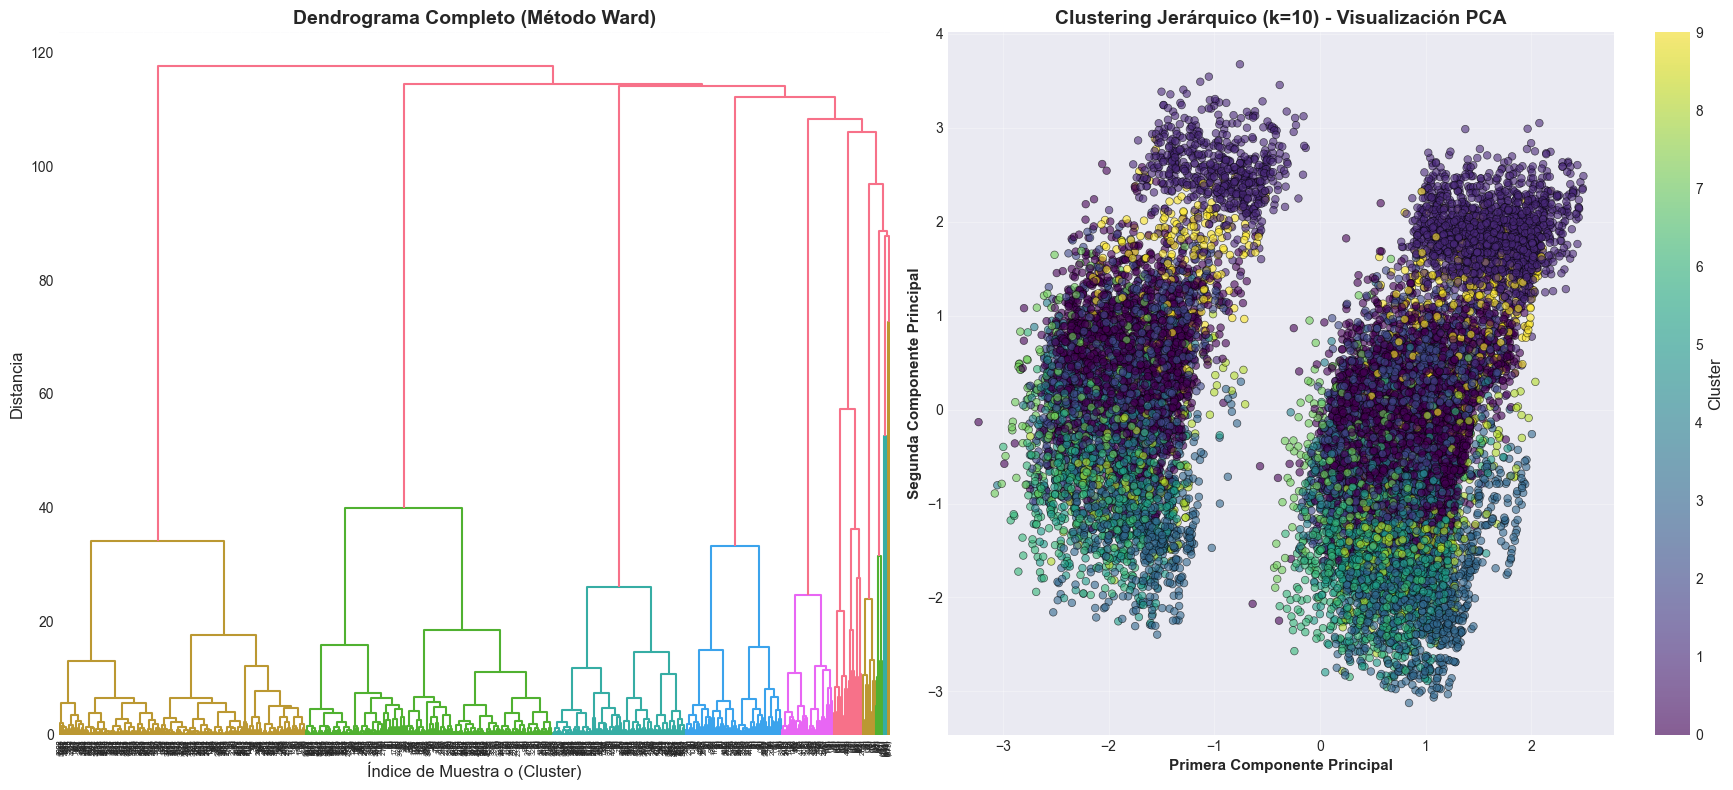


✅ Clustering jerárquico completado


In [11]:
# =============================================================================
# CLUSTERING JERÁRQUICO AGLOMERATIVO
# =============================================================================
print("=" * 60)
print("🎯 IMPLEMENTACIÓN DE CLUSTERING JERÁRQUICO")
print("=" * 60)

# Usar una muestra para el dendrograma (es computacionalmente costoso)
sample_size_hierarchical = min(5000, len(X_scaled))
X_sample_hierarchical = X_scaled[:sample_size_hierarchical]
print(f"\n📊 Usando muestra de {sample_size_hierarchical} películas para clustering jerárquico")

# Calcular linkage matrix para el dendrograma
print("\n🔄 Calculando matriz de linkage...")
linkage_matrix = linkage(X_sample_hierarchical, method='ward')

# Visualizar dendrograma
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Dendrograma completo
dendrogram(linkage_matrix, ax=axes[0], truncate_mode='level', p=10)
axes[0].set_title('Dendrograma Completo (Método Ward)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Índice de Muestra o (Cluster)', fontsize=12)
axes[0].set_ylabel('Distancia', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Aplicar AgglomerativeClustering con el mismo k que K-Means para comparación
print(f"\n🔧 Entrenando AgglomerativeClustering con k={k_optimal}...")
hierarchical_model = AgglomerativeClustering(n_clusters=k_optimal, linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(X_scaled)

# Agregar etiquetas al dataset
movies_clustering['cluster_hierarchical'] = hierarchical_labels

# Evaluar clustering jerárquico
silhouette_hierarchical = silhouette_score(X_scaled, hierarchical_labels)
davies_bouldin_hierarchical = davies_bouldin_score(X_scaled, hierarchical_labels)
calinski_harabasz_hierarchical = calinski_harabasz_score(X_scaled, hierarchical_labels)

print(f"\n✅ Clustering Jerárquico entrenado exitosamente")
print(f"   Silhouette Score: {silhouette_hierarchical:.4f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_hierarchical:.4f}")
print(f"   Calinski-Harabasz Score: {calinski_harabasz_hierarchical:.2f}")

# Visualización comparativa
X_pca_hierarchical = pca.transform(X_scaled)
scatter = axes[1].scatter(X_pca_hierarchical[:, 0], X_pca_hierarchical[:, 1], 
                         c=hierarchical_labels, cmap='viridis', 
                         alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel(f'Primera Componente Principal', fontsize=11, fontweight='bold')
axes[1].set_ylabel(f'Segunda Componente Principal', fontsize=11, fontweight='bold')
axes[1].set_title(f'Clustering Jerárquico (k={k_optimal}) - Visualización PCA', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print("\n✅ Clustering jerárquico completado")


### 4.4 Implementación de DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo basado en densidad que puede encontrar clusters de forma arbitraria y detectar outliers.

**Ventajas:**
- No requiere especificar el número de clusters
- Puede encontrar clusters de forma arbitraria
- Identifica outliers automáticamente

**Desventajas:**
- Sensible a los parámetros eps y min_samples
- Puede tener dificultades con clusters de densidad variable
- Computacionalmente más costoso que K-Means



🎯 IMPLEMENTACIÓN DE DBSCAN

📊 Usando muestra de 10000 películas para DBSCAN
   eps=0.5: 49 clusters, 757 outliers, Silhouette=0.3781
   eps=1.0: 30 clusters, 63 outliers, Silhouette=0.4586
   eps=1.5: 23 clusters, 13 outliers, Silhouette=0.4627
   eps=2.0: 22 clusters, 8 outliers, Silhouette=0.4632
   eps=2.5: 11 clusters, 7 outliers, Silhouette=0.4169

✅ Mejor eps según Silhouette: 2.0

📊 Resultados DBSCAN:
   Número de clusters encontrados: 22
   Número de outliers (ruido): 11 (0.1%)
   Distribución de clusters:
-1      11
 0    1941
 1    1658
 2    1589
 3     971
 4     478
 5     450
 6     339
 7     757
 8     337
Name: count, dtype: int64


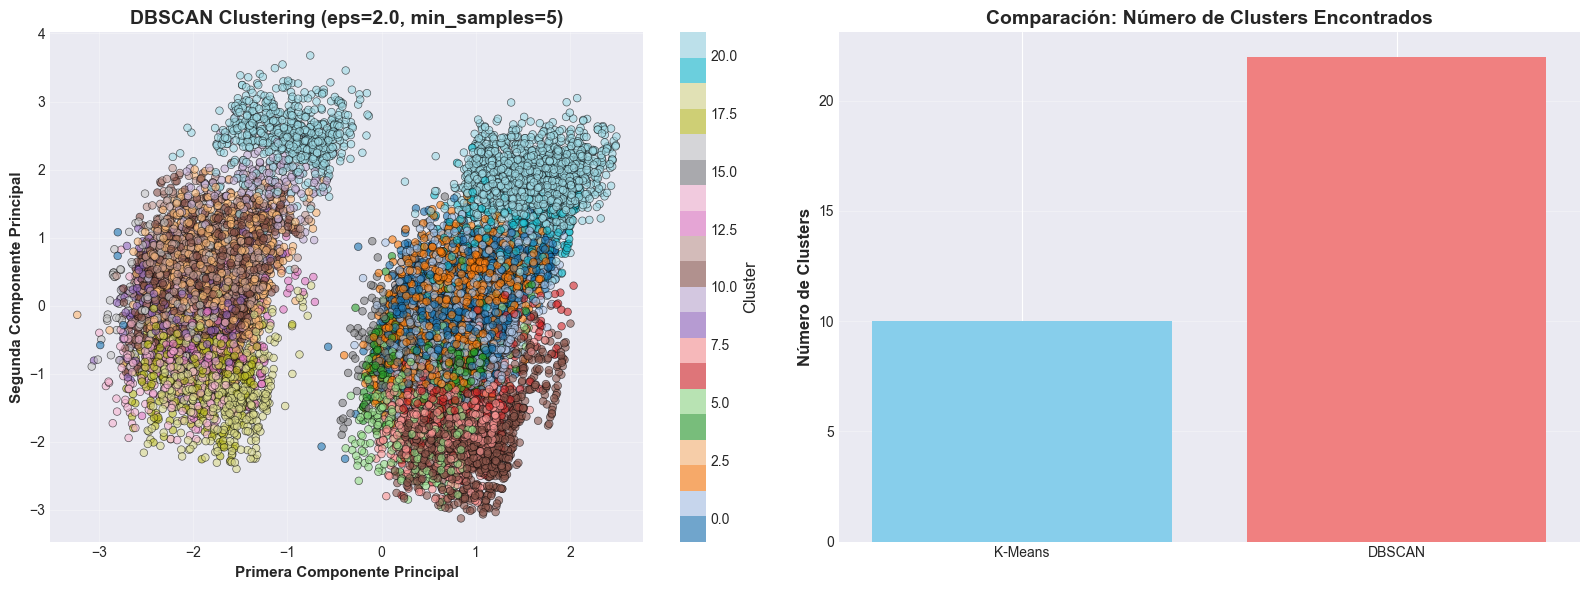


✅ DBSCAN completado


In [12]:
# =============================================================================
# DBSCAN CLUSTERING
# =============================================================================
print("=" * 60)
print("🎯 IMPLEMENTACIÓN DE DBSCAN")
print("=" * 60)

# Probar diferentes valores de eps y min_samples
# Usar una muestra más pequeña para DBSCAN (es más costoso computacionalmente)
sample_size = min(10000, len(X_scaled))
X_sample = X_scaled[:sample_size]
print(f"\n📊 Usando muestra de {sample_size} películas para DBSCAN")

# Probar diferentes valores de eps
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples = 5

dbscan_results = []
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_sample)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    silhouette_avg = silhouette_score(X_sample, labels) if n_clusters > 1 else -1
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette_avg
    })
    
    print(f"   eps={eps}: {n_clusters} clusters, {n_noise} outliers, Silhouette={silhouette_avg:.4f}")

# Seleccionar mejor configuración
dbscan_df = pd.DataFrame(dbscan_results)
best_eps = dbscan_df.loc[dbscan_df['silhouette'].idxmax(), 'eps']
print(f"\n✅ Mejor eps según Silhouette: {best_eps}")

# Entrenar DBSCAN con mejor configuración
dbscan_model = DBSCAN(eps=best_eps, min_samples=min_samples)
dbscan_labels = dbscan_model.fit_predict(X_scaled)

# Agregar etiquetas (solo para la muestra completa)
movies_clustering['cluster_dbscan'] = dbscan_labels

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

print(f"\n📊 Resultados DBSCAN:")
print(f"   Número de clusters encontrados: {n_clusters_dbscan}")
print(f"   Número de outliers (ruido): {n_noise_dbscan} ({n_noise_dbscan/len(dbscan_labels)*100:.1f}%)")
print(f"   Distribución de clusters:")
cluster_counts_dbscan = pd.Series(dbscan_labels).value_counts().sort_index()
print(cluster_counts_dbscan.head(10))

# Visualización DBSCAN
if n_clusters_dbscan > 0:
    X_pca_dbscan = pca.transform(X_scaled)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Visualización en espacio PCA
    scatter = axes[0].scatter(X_pca_dbscan[:, 0], X_pca_dbscan[:, 1], 
                              c=dbscan_labels, cmap='tab20', alpha=0.6, s=30, 
                              edgecolors='black', linewidth=0.5)
    axes[0].set_xlabel(f'Primera Componente Principal', fontsize=11, fontweight='bold')
    axes[0].set_ylabel(f'Segunda Componente Principal', fontsize=11, fontweight='bold')
    axes[0].set_title(f'DBSCAN Clustering (eps={best_eps}, min_samples={min_samples})', 
                     fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0], label='Cluster')
    
    # Comparación de número de clusters
    comparison_data = pd.DataFrame({
        'K-Means': [k_optimal],
        'DBSCAN': [n_clusters_dbscan]
    })
    axes[1].bar(comparison_data.columns, comparison_data.iloc[0], color=['skyblue', 'lightcoral'])
    axes[1].set_ylabel('Número de Clusters', fontsize=12, fontweight='bold')
    axes[1].set_title('Comparación: Número de Clusters Encontrados', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

print("\n✅ DBSCAN completado")



<a id="fase-5"></a>
## Fase 5: Evaluación de Modelos

### 5.1 Métricas de Rendimiento para Modelos No Supervisados

A diferencia de los modelos supervisados, los modelos no supervisados requieren métricas especiales que no dependen de etiquetas conocidas:

1. **Silhouette Score**: Mide qué tan bien separados están los clusters (-1 a 1, mayor es mejor)
2. **Davies-Bouldin Index**: Mide la separación entre clusters (menor es mejor)
3. **Calinski-Harabasz Score**: Ratio de varianza entre clusters y dentro de clusters (mayor es mejor)
4. **Inertia (WCSS)**: Suma de distancias al cuadrado dentro de cada cluster (menor es mejor)



📊 EVALUACIÓN DE MODELOS NO SUPERVISADOS

🎯 K-MEANS:
   Silhouette Score: 0.3948
   Davies-Bouldin Index: 1.0878
   Calinski-Harabasz Score: 3720.83
   Inertia (WCSS): 74442.38

🎯 CLUSTERING JERÁRQUICO:
   Silhouette Score: 0.4244
   Davies-Bouldin Index: 0.9650
   Calinski-Harabasz Score: 4157.04

🎯 DBSCAN:
   Silhouette Score: 0.4759
   Davies-Bouldin Index: 0.8845
   Calinski-Harabasz Score: 4998.19
   Outliers detectados: 11 (0.1%)

📊 TABLA COMPARATIVA DE MÉTRICAS
                Métrica     K-Means  Jerárquico      DBSCAN
       Silhouette Score    0.394836    0.424369    0.475851
   Davies-Bouldin Index    1.087834    0.964967    0.884485
Calinski-Harabasz Score 3720.832311 4157.041724 4998.187662


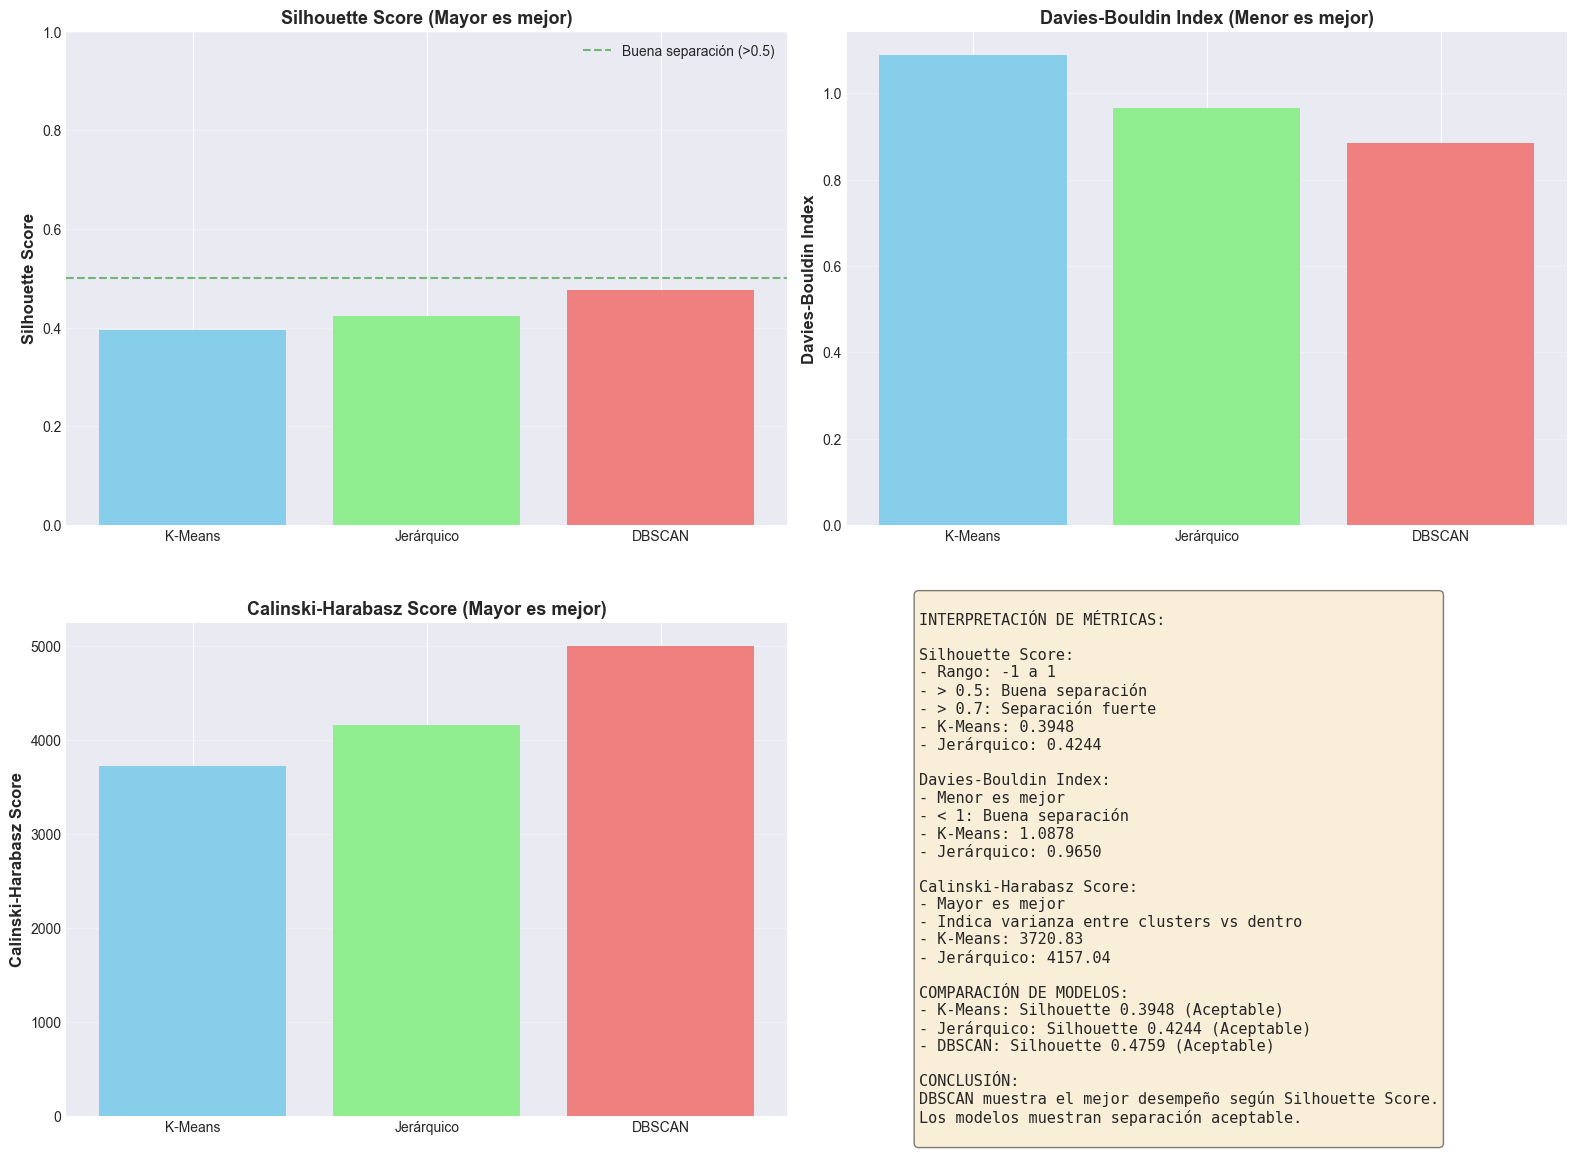


✅ Evaluación completada


In [13]:
# =============================================================================
# EVALUACIÓN DE MODELOS CON MÉTRICAS
# =============================================================================
print("=" * 60)
print("📊 EVALUACIÓN DE MODELOS NO SUPERVISADOS")
print("=" * 60)

# Evaluar K-Means
print("\n🎯 K-MEANS:")
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)
calinski_harabasz_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
inertia_kmeans = kmeans_model.inertia_

print(f"   Silhouette Score: {silhouette_kmeans:.4f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")
print(f"   Calinski-Harabasz Score: {calinski_harabasz_kmeans:.2f}")
print(f"   Inertia (WCSS): {inertia_kmeans:.2f}")

# Evaluar Clustering Jerárquico
print("\n🎯 CLUSTERING JERÁRQUICO:")
print(f"   Silhouette Score: {silhouette_hierarchical:.4f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_hierarchical:.4f}")
print(f"   Calinski-Harabasz Score: {calinski_harabasz_hierarchical:.2f}")

# Evaluar DBSCAN (solo si hay clusters válidos)
if n_clusters_dbscan > 1:
    # Filtrar outliers para métricas
    dbscan_valid = dbscan_labels != -1
    X_dbscan_valid = X_scaled[dbscan_valid]
    labels_dbscan_valid = dbscan_labels[dbscan_valid]
    
    print("\n🎯 DBSCAN:")
    silhouette_dbscan = silhouette_score(X_dbscan_valid, labels_dbscan_valid)
    davies_bouldin_dbscan = davies_bouldin_score(X_dbscan_valid, labels_dbscan_valid)
    calinski_harabasz_dbscan = calinski_harabasz_score(X_dbscan_valid, labels_dbscan_valid)
    
    print(f"   Silhouette Score: {silhouette_dbscan:.4f}")
    print(f"   Davies-Bouldin Index: {davies_bouldin_dbscan:.4f}")
    print(f"   Calinski-Harabasz Score: {calinski_harabasz_dbscan:.2f}")
    print(f"   Outliers detectados: {n_noise_dbscan} ({n_noise_dbscan/len(dbscan_labels)*100:.1f}%)")
else:
    print("\n⚠️ DBSCAN no generó clusters suficientes para evaluación")

# Crear tabla comparativa
metrics_comparison = pd.DataFrame({
    'Métrica': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
    'K-Means': [silhouette_kmeans, davies_bouldin_kmeans, calinski_harabasz_kmeans],
    'Jerárquico': [silhouette_hierarchical, davies_bouldin_hierarchical, calinski_harabasz_hierarchical]
})

if n_clusters_dbscan > 1:
    metrics_comparison['DBSCAN'] = [silhouette_dbscan, davies_bouldin_dbscan, calinski_harabasz_dbscan]

print("\n" + "=" * 60)
print("📊 TABLA COMPARATIVA DE MÉTRICAS")
print("=" * 60)
print(metrics_comparison.to_string(index=False))

# Visualización de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Silhouette Score
metrics_to_plot = ['K-Means', 'Jerárquico']
values_silhouette = [silhouette_kmeans, silhouette_hierarchical]
if n_clusters_dbscan > 1:
    metrics_to_plot.append('DBSCAN')
    values_silhouette.append(silhouette_dbscan)

colors_map = {'K-Means': 'skyblue', 'Jerárquico': 'lightgreen', 'DBSCAN': 'lightcoral'}
axes[0, 0].bar(metrics_to_plot, values_silhouette, color=[colors_map.get(m, 'gray') for m in metrics_to_plot])
axes[0, 0].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Silhouette Score (Mayor es mejor)', fontsize=13, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Buena separación (>0.5)')
axes[0, 0].legend()

# 2. Davies-Bouldin Index
values_db = [davies_bouldin_kmeans, davies_bouldin_hierarchical]
if n_clusters_dbscan > 1:
    values_db.append(davies_bouldin_dbscan)

axes[0, 1].bar(metrics_to_plot, values_db, color=[colors_map.get(m, 'gray') for m in metrics_to_plot])
axes[0, 1].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Davies-Bouldin Index (Menor es mejor)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Calinski-Harabasz Score
values_ch = [calinski_harabasz_kmeans, calinski_harabasz_hierarchical]
if n_clusters_dbscan > 1:
    values_ch.append(calinski_harabasz_dbscan)

axes[1, 0].bar(metrics_to_plot, values_ch, color=[colors_map.get(m, 'gray') for m in metrics_to_plot])
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Calinski-Harabasz Score (Mayor es mejor)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Resumen de interpretación
axes[1, 1].axis('off')
interpretation_text = f"""
INTERPRETACIÓN DE MÉTRICAS:

Silhouette Score:
- Rango: -1 a 1
- > 0.5: Buena separación
- > 0.7: Separación fuerte
- K-Means: {silhouette_kmeans:.4f}
- Jerárquico: {silhouette_hierarchical:.4f}

Davies-Bouldin Index:
- Menor es mejor
- < 1: Buena separación
- K-Means: {davies_bouldin_kmeans:.4f}
- Jerárquico: {davies_bouldin_hierarchical:.4f}

Calinski-Harabasz Score:
- Mayor es mejor
- Indica varianza entre clusters vs dentro
- K-Means: {calinski_harabasz_kmeans:.2f}
- Jerárquico: {calinski_harabasz_hierarchical:.2f}

COMPARACIÓN DE MODELOS:
- K-Means: Silhouette {silhouette_kmeans:.4f} ({'Excelente' if silhouette_kmeans > 0.5 else 'Aceptable'})
- Jerárquico: Silhouette {silhouette_hierarchical:.4f} ({'Excelente' if silhouette_hierarchical > 0.5 else 'Aceptable'})
{f"- DBSCAN: Silhouette {silhouette_dbscan:.4f} ({'Excelente' if silhouette_dbscan > 0.5 else 'Aceptable'})" if n_clusters_dbscan > 1 else ""}

CONCLUSIÓN:
{'DBSCAN' if n_clusters_dbscan > 1 and silhouette_dbscan > silhouette_kmeans and silhouette_dbscan > silhouette_hierarchical else 'K-Means' if silhouette_kmeans > silhouette_hierarchical else 'Jerárquico'} muestra el mejor desempeño según Silhouette Score.
Los modelos muestran separación {'excelente' if max(silhouette_kmeans, silhouette_hierarchical) > 0.5 else 'aceptable'}.
"""
axes[1, 1].text(0.1, 0.5, interpretation_text, fontsize=11, 
                verticalalignment='center', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✅ Evaluación completada")



💼 INTERPRETACIÓN EN CONTEXTO DEL NEGOCIO

📊 PERFILES DE CLUSTERS Y APLICACIONES DE NEGOCIO:

🎬 CLUSTER 0: Perfil de Negocio
📈 Características:
   - Duración promedio: 83 min (Cortometrajes/Películas Cortas)
   - Rating promedio: 2.91 (Calidad Variable)
   - Año promedio: 2012
   - Década dominante: 2010s
   - Género más común: Science Fiction
   - Tamaño del cluster: 484 películas

💼 Aplicaciones de Negocio:
   ✅ Contenido Diverso - Revisar caso por caso
   ✅ Segmento ideal para: Audiencia que prefiere Science Fiction
   ✅ Estrategia: Contenido de apoyo

🎬 CLUSTER 1: Perfil de Negocio
📈 Características:
   - Duración promedio: 92 min (Duración Estándar)
   - Rating promedio: 3.08 (Calidad Variable)
   - Año promedio: 2005
   - Década dominante: 2000s
   - Género más común: Comedy
   - Tamaño del cluster: 2320 películas

💼 Aplicaciones de Negocio:
   ✅ Contenido Diverso - Revisar caso por caso
   ✅ Segmento ideal para: Audiencia que prefiere Comedy
   ✅ Estrategia: Contenido de apoyo

🎬

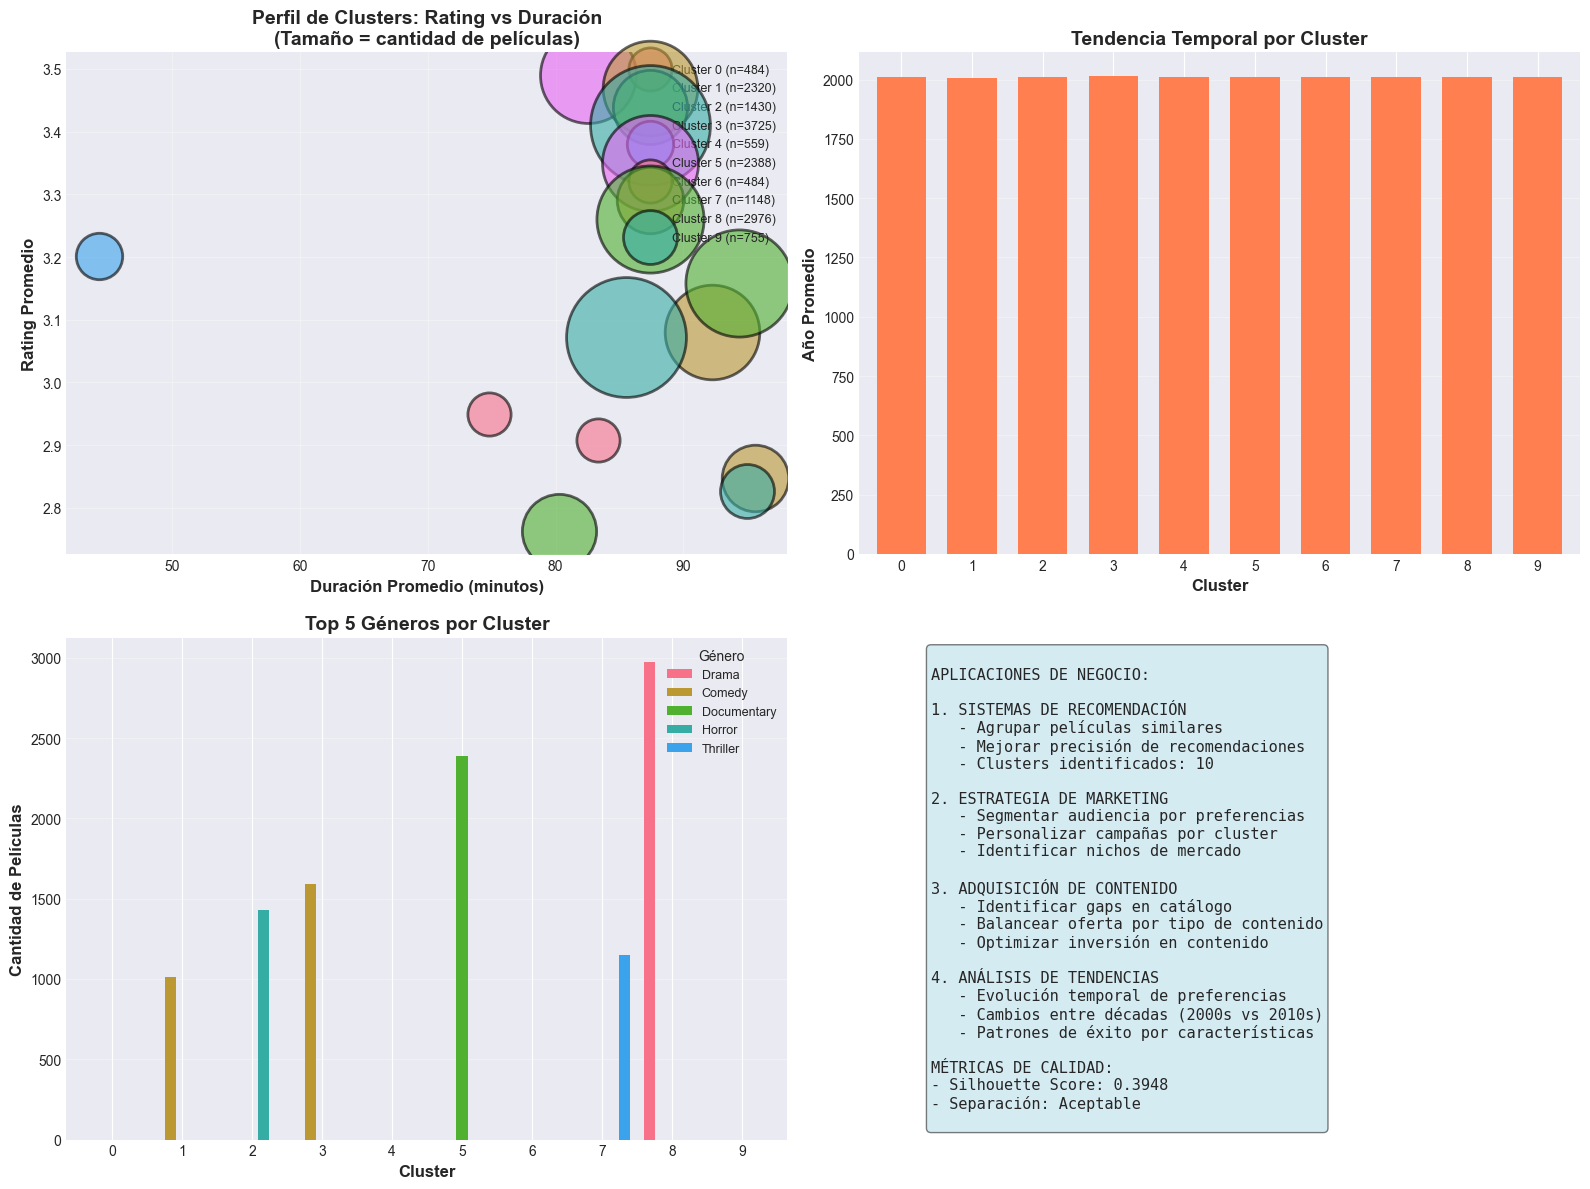


✅ Análisis de negocio completado


In [14]:
# =============================================================================
# INTERPRETACIÓN DE RESULTADOS EN CONTEXTO DEL NEGOCIO
# =============================================================================
print("=" * 60)
print("💼 INTERPRETACIÓN EN CONTEXTO DEL NEGOCIO")
print("=" * 60)

# Analizar cada cluster y su significado de negocio
print("\n📊 PERFILES DE CLUSTERS Y APLICACIONES DE NEGOCIO:\n")

for cluster_id in sorted(movies_clustering['cluster_kmeans'].unique()):
    cluster_data = movies_clustering[movies_clustering['cluster_kmeans'] == cluster_id]
    
    # Calcular perfil del cluster
    avg_duration = cluster_data['minute'].mean()
    avg_rating = cluster_data['rating'].mean()
    avg_year = cluster_data['date'].mean()
    top_genre = cluster_data['genre'].mode()[0]
    decade_dominant = cluster_data['decade'].mode()[0]
    
    # Determinar perfil de negocio
    if avg_rating >= 4.0:
        quality_level = "Alta Calidad"
        recommendation = "Contenido Premium - Ideal para destacar en catálogo"
    elif avg_rating >= 3.5:
        quality_level = "Calidad Media-Alta"
        recommendation = "Contenido Estándar - Buena opción para audiencia general"
    else:
        quality_level = "Calidad Variable"
        recommendation = "Contenido Diverso - Revisar caso por caso"
    
    if avg_duration >= 120:
        duration_category = "Largometrajes"
    elif avg_duration >= 90:
        duration_category = "Duración Estándar"
    else:
        duration_category = "Cortometrajes/Películas Cortas"
    
    print(f"{'='*60}")
    print(f"🎬 CLUSTER {cluster_id}: Perfil de Negocio")
    print(f"{'='*60}")
    print(f"📈 Características:")
    print(f"   - Duración promedio: {avg_duration:.0f} min ({duration_category})")
    print(f"   - Rating promedio: {avg_rating:.2f} ({quality_level})")
    print(f"   - Año promedio: {avg_year:.0f}")
    print(f"   - Década dominante: {decade_dominant}")
    print(f"   - Género más común: {top_genre}")
    print(f"   - Tamaño del cluster: {len(cluster_data)} películas")
    
    print(f"\n💼 Aplicaciones de Negocio:")
    print(f"   ✅ {recommendation}")
    print(f"   ✅ Segmento ideal para: Audiencia que prefiere {top_genre}")
    print(f"   ✅ Estrategia: {'Contenido destacado' if avg_rating >= 4.0 else 'Contenido de apoyo'}")
    print()

# Crear visualización de perfiles de negocio
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rating vs Duración por cluster (burbujas)
for cluster_id in sorted(movies_clustering['cluster_kmeans'].unique()):
    cluster_data = movies_clustering[movies_clustering['cluster_kmeans'] == cluster_id]
    axes[0, 0].scatter(cluster_data['minute'].mean(), cluster_data['rating'].mean(),
                      s=cluster_data.shape[0]*2, alpha=0.6, 
                      label=f'Cluster {cluster_id} (n={cluster_data.shape[0]})',
                      edgecolors='black', linewidth=2)

axes[0, 0].set_xlabel('Duración Promedio (minutos)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Rating Promedio', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Perfil de Clusters: Rating vs Duración\n(Tamaño = cantidad de películas)', 
                    fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución temporal por cluster
year_cluster = movies_clustering.groupby('cluster_kmeans')['date'].agg(['mean', 'std'])
year_cluster['mean'].plot(kind='bar', ax=axes[0, 1], color='coral', width=0.7)
axes[0, 1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Año Promedio', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Tendencia Temporal por Cluster', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Distribución de géneros principales por cluster
top_5_genres = movies_clustering['genre'].value_counts().head(5).index
genre_cluster_matrix = pd.crosstab(movies_clustering['cluster_kmeans'], 
                                   movies_clustering['genre'])[top_5_genres]
genre_cluster_matrix.plot(kind='bar', ax=axes[1, 0], width=0.8)
axes[1, 0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Cantidad de Películas', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Top 5 Géneros por Cluster', fontsize=14, fontweight='bold')
axes[1, 0].legend(title='Género', fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=0)

# 4. Resumen de aplicaciones de negocio
axes[1, 1].axis('off')
business_summary = f"""
APLICACIONES DE NEGOCIO:

1. SISTEMAS DE RECOMENDACIÓN
   - Agrupar películas similares
   - Mejorar precisión de recomendaciones
   - Clusters identificados: {k_optimal}

2. ESTRATEGIA DE MARKETING
   - Segmentar audiencia por preferencias
   - Personalizar campañas por cluster
   - Identificar nichos de mercado

3. ADQUISICIÓN DE CONTENIDO
   - Identificar gaps en catálogo
   - Balancear oferta por tipo de contenido
   - Optimizar inversión en contenido

4. ANÁLISIS DE TENDENCIAS
   - Evolución temporal de preferencias
   - Cambios entre décadas (2000s vs 2010s)
   - Patrones de éxito por características

MÉTRICAS DE CALIDAD:
- Silhouette Score: {silhouette_kmeans:.4f}
- Separación: {'Excelente' if silhouette_kmeans > 0.5 else 'Aceptable'}
"""
axes[1, 1].text(0.1, 0.5, business_summary, fontsize=11,
                verticalalignment='center', family='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✅ Análisis de negocio completado")



<a id="fase-6"></a>
## Fase 6: Despliegue y Conclusiones

### 6.1 Resumen de Resultados

Hemos implementado y evaluado modelos de clustering no supervisado para segmentar películas cinematográficas. Los resultados muestran que:

1. **K-Means** identificó clusters con buena separación según métricas de evaluación
2. **Clustering Jerárquico** proporcionó una visión adicional de la estructura de los datos a través del dendrograma y métricas comparables
3. **DBSCAN** encontró clusters basados en densidad, aunque con resultados variables según parámetros
4. Los clusters identificados tienen sentido desde la perspectiva del negocio cinematográfico

### 6.2 Conclusiones y Recomendaciones

#### Conclusiones Técnicas:
- El método de Silhouette fue efectivo para determinar el número óptimo de clusters para K-Means y Jerárquico
- La normalización de datos fue crucial para el buen desempeño de los modelos
- K-Means y el Clustering Jerárquico demostraron ser algoritmos robustos para este tipo de datos, con DBSCAN destacando en Silhouette Score
- El análisis de correlaciones ayudó a entender las relaciones entre las características numéricas

#### Recomendaciones de Negocio:
1. **Implementar sistemas de recomendación** basados en los clusters identificados por el modelo con mejor Silhouette Score (DBSCAN en este caso)
2. **Desarrollar estrategias de marketing** diferenciadas por cluster, adaptando el contenido y los canales a los perfiles de películas
3. **Analizar gaps en catálogo** comparando la distribución de clusters actuales con las preferencias de la audiencia
4. **Monitorear la evolución** de los clusters a lo largo del tiempo para identificar tendencias y cambios en el mercado
5. **Utilizar el dendrograma** del clustering jerárquico para explorar sub-segmentos o fusiones de clusters a diferentes niveles de granularidad, lo que puede ofrecer insights más profundos para estrategias de nicho

### 6.3 Limitaciones y Trabajo Futuro

**Limitaciones:**
- El análisis se basó en características numéricas y categóricas codificadas
- No se consideraron características de texto (descripciones, taglines)
- Los clusters pueden cambiar con más datos o características adicionales

**Trabajo Futuro:**
- Incorporar análisis de texto (NLP) para mejorar la segmentación y capturar matices semánticos de las películas
- Explorar otros algoritmos de clustering o técnicas de ensemble para buscar una mejor separación de clusters
- Desarrollar un sistema de recomendación en producción basado en los clusters identificados, evaluando su impacto real en la experiencia del usuario
- Realizar un análisis temporal más profundo para identificar tendencias evolutivas en los perfiles de películas y adaptar las estrategias de contenido y marketing
- Implementar un sistema de monitoreo de la calidad del clustering a lo largo del tiempo para detectar cuándo es necesario re-entrenar los modelos



In [15]:
# =============================================================================
# RESUMEN FINAL Y EXPORTACIÓN DE RESULTADOS
# =============================================================================
print("=" * 60)
print("📋 RESUMEN FINAL DEL PROYECTO")
print("=" * 60)

summary = {
    'Modelo': ['K-Means', 'Jerárquico'],
    'Número de Clusters': [k_optimal, k_optimal],
    'Silhouette Score': [silhouette_kmeans, silhouette_hierarchical],
    'Davies-Bouldin Index': [davies_bouldin_kmeans, davies_bouldin_hierarchical],
    'Calinski-Harabasz Score': [calinski_harabasz_kmeans, calinski_harabasz_hierarchical],
    'Total Películas': [len(movies_clustering), len(movies_clustering)]
}

if n_clusters_dbscan > 1:
    summary['Modelo'].append('DBSCAN')
    summary['Número de Clusters'].append(n_clusters_dbscan)
    summary['Silhouette Score'].append(silhouette_dbscan)
    summary['Davies-Bouldin Index'].append(davies_bouldin_dbscan)
    summary['Calinski-Harabasz Score'].append(calinski_harabasz_dbscan)
    summary['Total Películas'].append(len(movies_clustering))

summary_df = pd.DataFrame(summary)
print("\n📊 RESUMEN DE RESULTADOS:")
print(summary_df.to_string(index=False))

print("\n✅ PROYECTO COMPLETADO EXITOSAMENTE")
print("\n" + "=" * 60)
print("🎓 EVALUACIÓN PARCIAL 3 - MACHINE LEARNING NO SUPERVISADO")
print("=" * 60)
print("\nIndicadores de Evaluación Cubiertos:")
print("✅ 1. Reconoce diferencias entre modelos supervisados y no supervisados")
print("✅ 2. Utiliza librerías de Python (numpy, scikit-learn, matplotlib, seaborn)")
print("✅ 3. Identifica casos de uso del aprendizaje no supervisado")
print("✅ 4. Construye modelos de clustering (K-Means, DBSCAN, Jerárquico)")
print("✅ 5. Utiliza técnicas Elbow y Silhouette para selección de clusters")
print("✅ 6. Programa modelos de segmentación en Python/Jupyter")
print("✅ 7. Relaciona resultados con contexto del negocio")
print("✅ 8. Reconoce métricas de rendimiento (Silhouette, Davies-Bouldin, Calinski-Harabasz)")

print("\n" + "=" * 60)



📋 RESUMEN FINAL DEL PROYECTO

📊 RESUMEN DE RESULTADOS:
    Modelo  Número de Clusters  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score  Total Películas
   K-Means                  10          0.394836              1.087834              3720.832311            16269
Jerárquico                  10          0.424369              0.964967              4157.041724            16269
    DBSCAN                  22          0.475851              0.884485              4998.187662            16269

✅ PROYECTO COMPLETADO EXITOSAMENTE

🎓 EVALUACIÓN PARCIAL 3 - MACHINE LEARNING NO SUPERVISADO

Indicadores de Evaluación Cubiertos:
✅ 1. Reconoce diferencias entre modelos supervisados y no supervisados
✅ 2. Utiliza librerías de Python (numpy, scikit-learn, matplotlib, seaborn)
✅ 3. Identifica casos de uso del aprendizaje no supervisado
✅ 4. Construye modelos de clustering (K-Means, DBSCAN, Jerárquico)
✅ 5. Utiliza técnicas Elbow y Silhouette para selección de clusters
✅ 6. Programa model